In [1]:
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import pandas as pd
import theano.tensor as tt
import matplotlib.pyplot as plt
import arviz as az

In [2]:
az.style.use('arviz-darkgrid')

In [3]:
np.random.seed(42)

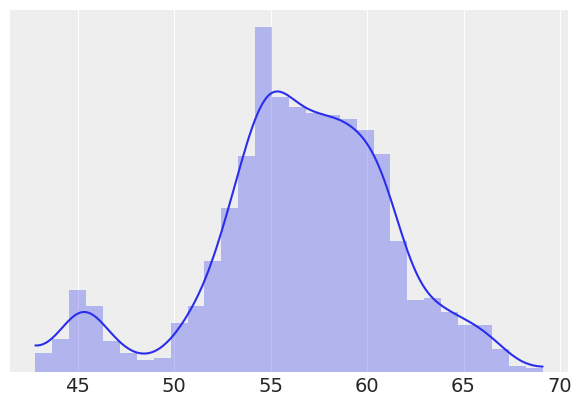

In [4]:
cs = pd.read_csv('../data/chemical_shifts_theo_exp.csv')
cs_exp = cs['exp']
az.plot_kde(cs_exp)
plt.hist(cs_exp, density=True, bins=30, alpha=0.3)
plt.yticks([])
plt.savefig('B11197_06_02.png')

In [5]:
#with pm.Model() as model_kg:
#    p = pm.Dirichlet('p', a=np.ones(clusters))
#    z = pm.Categorical('z', p=p, shape=len(cs_exp))
#    means = pm.Normal('means', mu=cs_exp.mean(), sd=10, shape=clusters)
#    sd = pm.HalfNormal('sd', sd=10)
#
#    y = pm.Normal('y', mu=means[z], sd=sd, observed=cs_exp)
#    trace_kg = pm.sample()

In [6]:
clusters = 2
with pm.Model() as model_mg:
    p = pm.Dirichlet('p', a=np.ones(clusters))
    means = pm.Normal('means', mu=cs_exp.mean(), sd=10, shape=clusters)
    sd = pm.HalfNormal('sd', sd=10)
    y = pm.NormalMixture('y', w=p, mu=means, sd=sd, observed=cs_exp)
    trace_mg = pm.sample(random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, means, p]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:03<00:00, 521.95draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


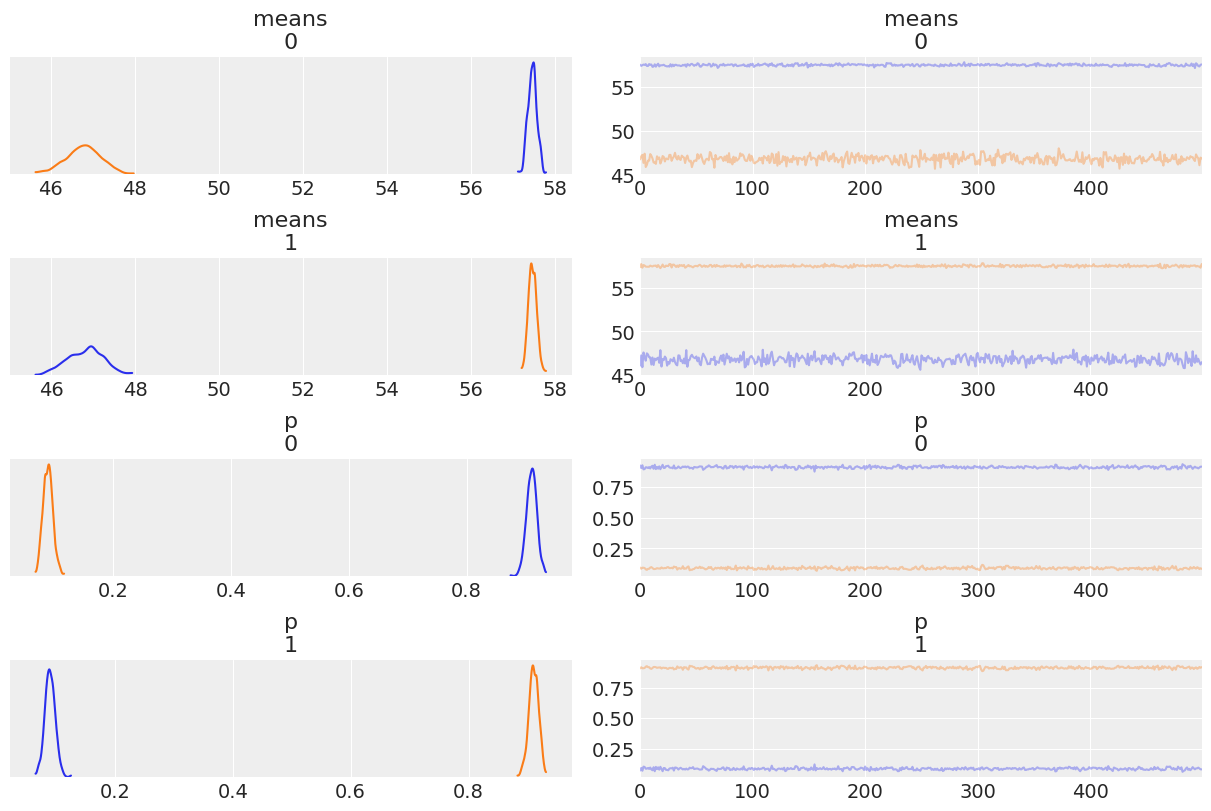

In [7]:
varnames = ['means', 'p']
az.plot_trace(trace_mg, varnames)
plt.savefig('B11197_06_06.png')

In [8]:
az.summary(trace_mg, varnames)

,mean,sd,mc error,hpd 3%,hpd 97%,eff_n,r_hat
means[0],52.12,5.35,2.14,46.24,57.68,1.0,25.19
means[1],52.14,5.33,2.13,46.23,57.65,1.0,24.52
p[0],0.50,0.41,0.16,0.08,0.92,1.0,68.91
p[1],0.50,0.41,0.16,0.08,0.92,1.0,68.91


## Non-identifiability of mixture models

In [9]:
clusters = 2
with pm.Model() as model_mgp:
    p = pm.Dirichlet('p', a=np.ones(clusters))
    means = pm.Normal('means', mu=np.array([.9, 1]) * cs_exp.mean(),
                      sd=10, shape=clusters)
    sd = pm.HalfNormal('sd', sd=10)
    order_means = pm.Potential('order_means',
                               tt.switch(means[1]-means[0] < 0,
                                         -np.inf, 0))
    y = pm.NormalMixture('y', w=p, mu=means, sd=sd, observed=cs_exp)
    trace_mgp = pm.sample(1000, random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, means, p]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:05<00:00, 584.95draws/s]


In [10]:
# instead of a potential we can use an ordered transformation
# transform=pm.distributions.transforms.ordered

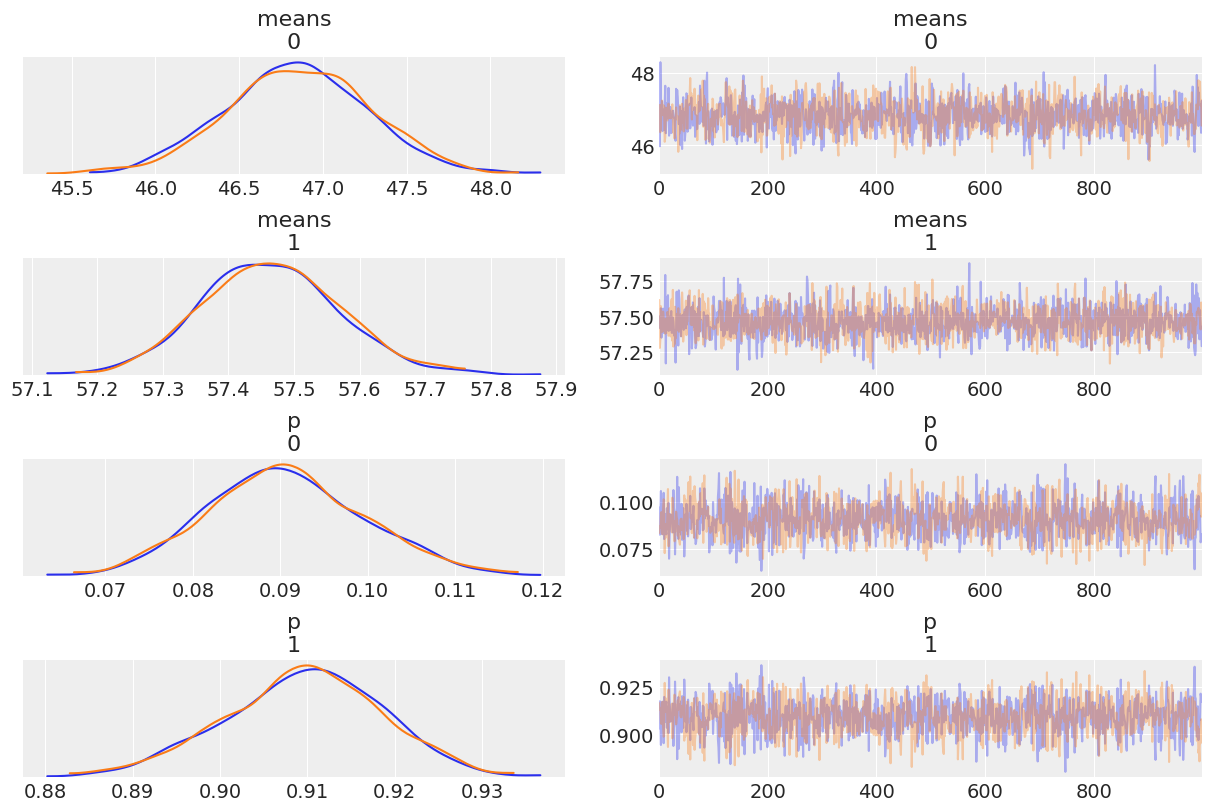

In [11]:
varnames = ['means', 'p']
az.plot_trace(trace_mgp, varnames)
plt.savefig('B11197_06_07.png')

In [12]:
az.summary(trace_mgp)

,mean,sd,mc error,hpd 3%,hpd 97%,eff_n,r_hat
means[0],46.84,0.42,0.01,46.04,47.61,1328.0,1.0
means[1],57.46,0.10,0.00,57.26,57.65,2162.0,1.0
p[0],0.09,0.01,0.00,0.07,0.11,1365.0,1.0
p[1],0.91,0.01,0.00,0.89,0.93,1365.0,1.0
sd,3.65,0.07,0.00,3.51,3.78,1959.0,1.0


## How to choose K

In [13]:
clusters = [3, 4, 5, 6]

models = []
traces = []
for cluster in clusters:
    with pm.Model() as model:
        p = pm.Dirichlet('p', a=np.ones(cluster))
        means = pm.Normal('means',
                          mu=np.linspace(cs_exp.min(), cs_exp.max(), cluster),
                          sd=10, shape=cluster,
                          transform=pm.distributions.transforms.ordered)
        sd = pm.HalfNormal('sd', sd=10)
        y = pm.NormalMixture('y', w=p, mu=means, sd=sd, observed=cs_exp)
        trace = pm.sample(1000, tune=2000, random_seed=123)
        traces.append(trace)
        models.append(model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, means, p]
Sampling 2 chains: 100%|██████████| 6000/6000 [00:30<00:00, 199.77draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, means, p]
Sampling 2 chains: 100%|██████████| 6000/6000 [00:30<00:00, 197.99draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, means, p]
Sampling 2 chains: 100%|██████████| 6000/6000 [01:00<00:00, 52.24draws/s] 
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, means, p]
Sampling 2 chains: 100%|██████████| 6000/6000 [02:04<00:00, 41.54draws/s]
The acceptance probability does not match the target. It i

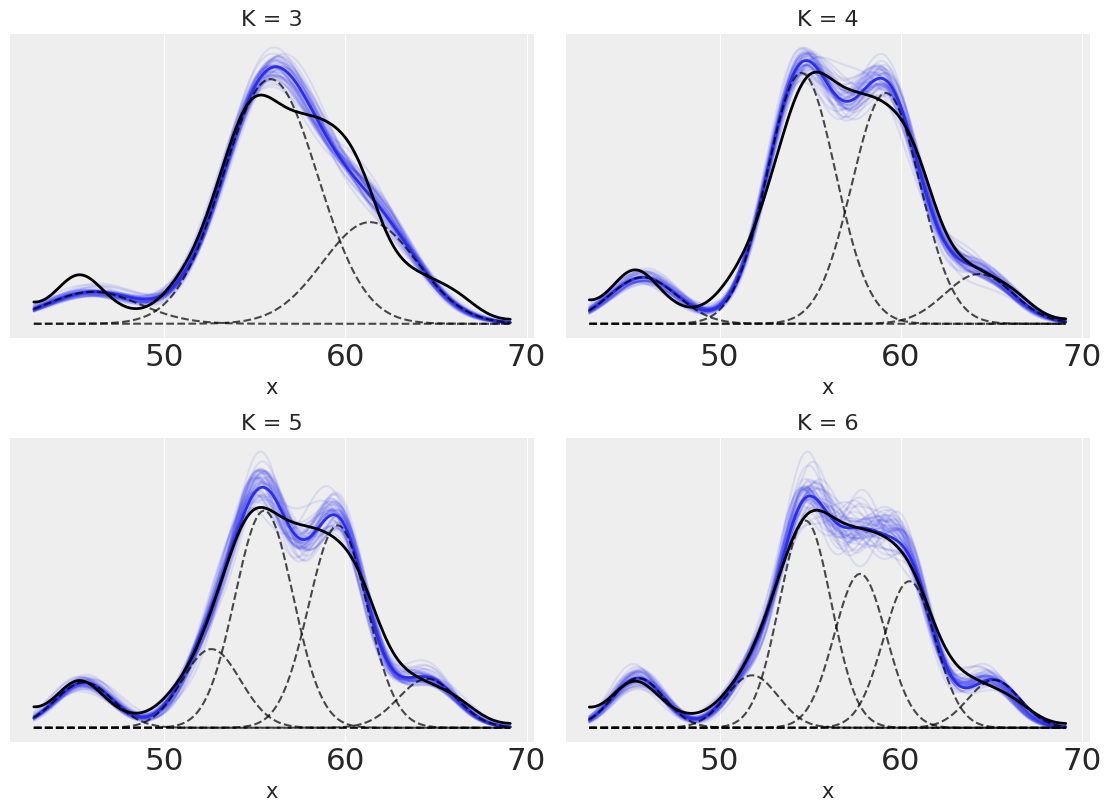

In [14]:
_, ax = plt.subplots(2, 2, figsize=(11, 8), constrained_layout=True)
 
ax = np.ravel(ax)
x = np.linspace(cs_exp.min(), cs_exp.max(), 200)
for idx, trace_x in enumerate(traces):
    x_ = np.array([x] * clusters[idx]).T
 
    for i in range(50):
        i_ = np.random.randint(0, len(trace_x))
        means_y = trace_x['means'][i_]
        p_y = trace_x['p'][i_]
        sd = trace_x['sd'][i_]
        dist = stats.norm(means_y, sd)
        ax[idx].plot(x, np.sum(dist.pdf(x_) * p_y, 1), 'C0', alpha=0.1)
 
    means_y = trace_x['means'].mean(0)
    p_y = trace_x['p'].mean(0)
    sd = trace_x['sd'].mean()
    dist = stats.norm(means_y, sd)
    ax[idx].plot(x, np.sum(dist.pdf(x_) * p_y, 1), 'C0', lw=2)
    ax[idx].plot(x, dist.pdf(x_) * p_y, 'k--', alpha=0.7)
         
    az.plot_kde(cs_exp, plot_kwargs={'linewidth':2, 'color':'k'}, ax=ax[idx])
    ax[idx].set_title('K = {}'.format(clusters[idx]))
    ax[idx].set_yticks([])
    ax[idx].set_xlabel('x')
plt.savefig('B11197_06_08.png')

In [15]:
ppc_mm = [pm.sample_posterior_predictive(traces[i], 1000, models[i])
          for i in range(4)]

100%|██████████| 1000/1000 [00:01<00:00, 790.24it/s]


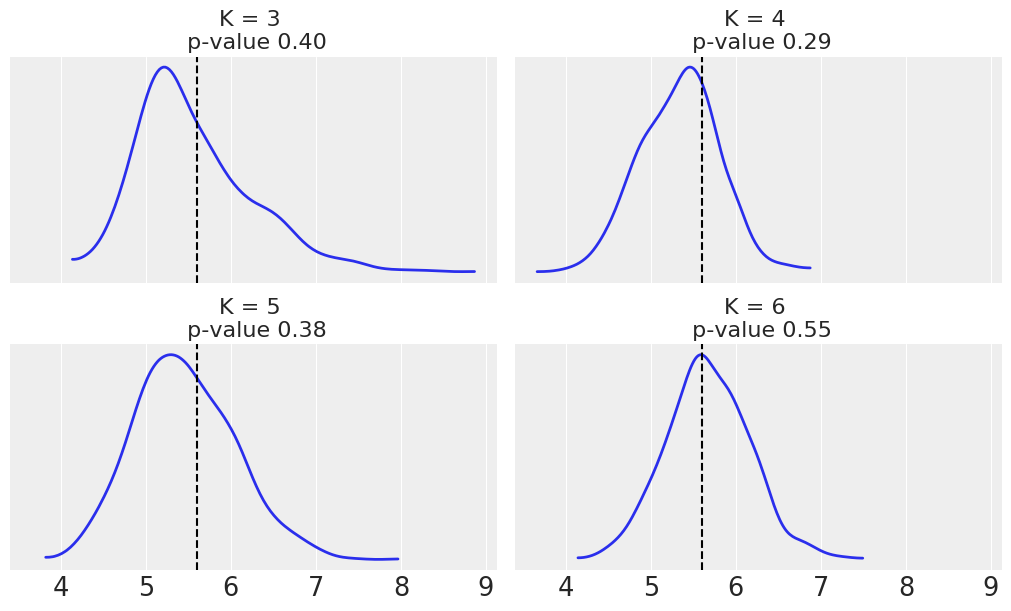

In [16]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6), sharex=True, constrained_layout=True)
ax = np.ravel(ax)
def iqr(x, a=0):
    return np.subtract(*np.percentile(x, [75, 25], axis=a))

T_obs = iqr(cs_exp)
for idx, d_sim in enumerate(ppc_mm):
    T_sim = iqr(d_sim['y'][:100].T, 1)
    p_value = np.mean(T_sim >= T_obs)
    az.plot_kde(T_sim, ax=ax[idx])
    ax[idx].axvline(T_obs, 0, 1, color='k', ls='--')
    ax[idx].set_title(f'K = {clusters[idx]} \n p-value {p_value:.2f}')
    ax[idx].set_yticks([])
plt.savefig('B11197_06_09.png')

In [17]:
comp = az.compare(dict(zip(clusters, traces)), method='BB-pseudo-BMA')
comp

,waic,pwaic,dwaic,weight,se,dse,warning
6,10250,12.368,0,0.948361,62.7354,0,0
5,10259.7,10.3531,9.69981,0.0472388,61.3804,4.6348,0
4,10278.9,7.45718,28.938,0.00440011,60.7985,9.82746,0
3,10356.9,5.90559,106.926,3.19235e-13,60.9242,18.5501,0


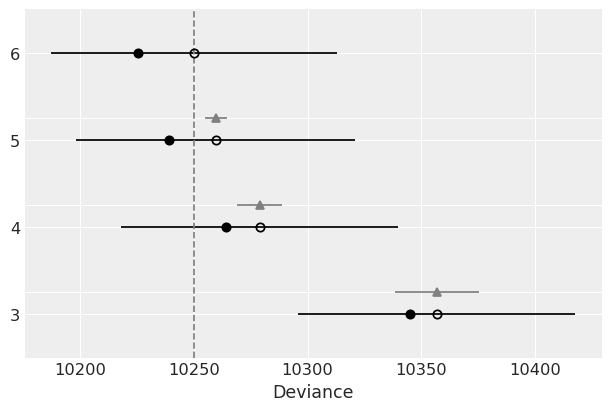

In [18]:
az.plot_compare(comp)
plt.savefig('B11197_06_10.png')

## Non-finite mixture model

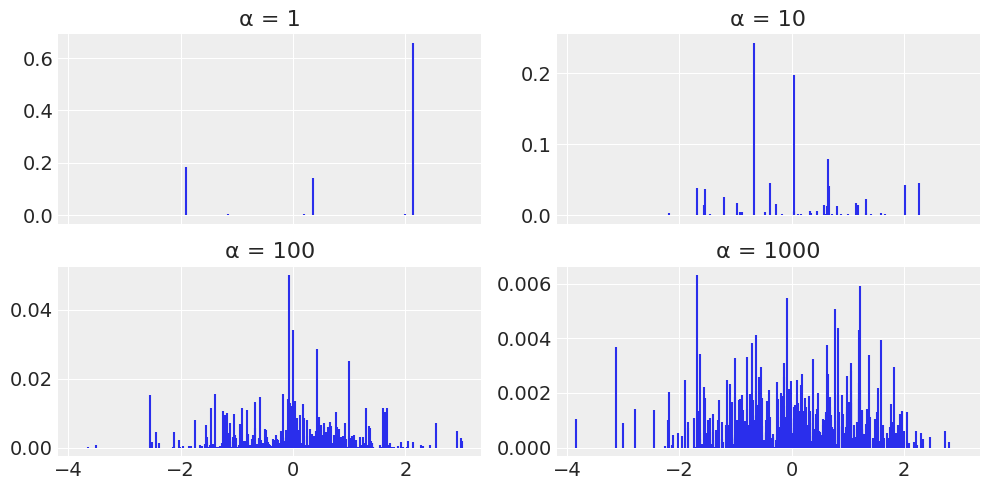

In [19]:
def stick_breaking_truncated(α, H, K):
    """
    Truncated stick-breaking process view of a DP
    
    Parameters
    ----------
    α : float
        concentration parameter
    H : scipy distribution
        Base distribution
    K : int
        number of components
    
    Returns
    -------
    locs : array
        locations
    w : array
        probabilities
    """
    βs = stats.beta.rvs(1, α, size=K)
    w = np.empty(K)
    w = βs * np.concatenate(([1.], np.cumprod(1 - βs[:-1])))
    locs = H.rvs(size=K)
    return locs, w

# Parameters DP
K = 500
H = stats.norm
alphas = [1, 10, 100, 1000]

# plot
_, ax = plt.subplots(2, 2, sharex=True, figsize=(10, 5))
ax = np.ravel(ax)
for idx, α in enumerate(alphas):
    locs, w = stick_breaking_truncated(α, H, K)
    ax[idx].vlines(locs, 0, w, color='C0')
    ax[idx].set_title('α = {}'.format(α))

plt.tight_layout()
plt.savefig('B11197_06_11.png')

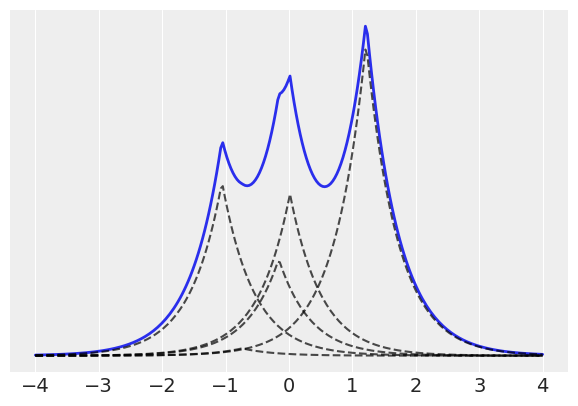

In [20]:
α = 10
H = stats.norm
K = 5

x = np.linspace(-4, 4, 250)
x_ = np.array([x] * K).T
locs, w = stick_breaking_truncated(α, H, K)

dist = stats.laplace(locs, 0.5)
plt.plot(x, np.sum(dist.pdf(x_) * w, 1), 'C0', lw=2)
plt.plot(x, dist.pdf(x_) * w, 'k--', alpha=0.7)
plt.yticks([])
plt.savefig('B11197_06_12.png')

In [21]:
K = 20

def stick_breaking(α, K):
    β = pm.Beta('β', 1., α, shape=K)
    w = β * pm.math.concatenate([[1.], tt.extra_ops.cumprod(1. - β)[:-1]])
    return w

In [22]:
with pm.Model() as model:
    α = pm.Gamma('α', 1, 1.)
    w = pm.Deterministic('w', stick_breaking(α, K))
    means = pm.Normal('means',
                      mu=np.linspace(cs_exp.min(), cs_exp.max(), K),
                      sd=10, shape=K)
    
    sd = pm.HalfNormal('sd', sd=10, shape=K)
    obs = pm.NormalMixture('obs', w, means, sd=sd, observed=cs_exp.values)
    trace = pm.sample(1000, tune=2000, nuts_kwargs={'target_accept':0.85})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, means, β, α]
Sampling 2 chains: 100%|██████████| 6000/6000 [07:35<00:00, 12.74draws/s] 
There were 79 divergences after tuning. Increase `target_accept` or reparameterize.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


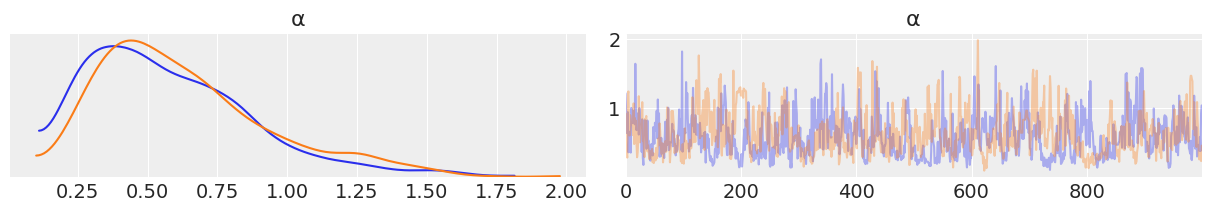

In [28]:
az.plot_trace(trace, var_names=['α'], divergences=False);
plt.savefig('B11197_06_13.png')

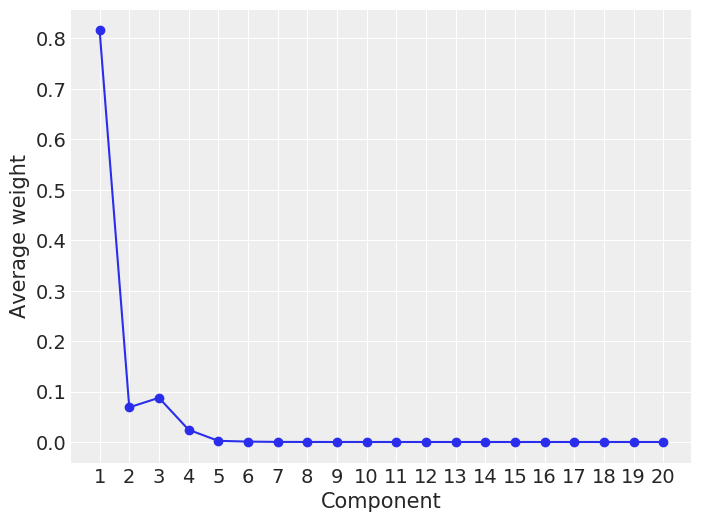

In [29]:
plt.figure(figsize=(8, 6))
plot_w = np.arange(K)
plt.plot(plot_w, trace['w'].mean(0), 'o-')
plt.xticks(plot_w, plot_w+1)
plt.xlabel('Component')
plt.ylabel('Average weight')
plt.savefig('B11197_06_14.png')

In [30]:
x_plot = np.linspace(cs.exp.min()-1, cs.exp.max()+1, 200)

post_pdf_contribs = stats.norm.pdf(np.atleast_3d(x_plot),
                                   trace['means'][:, np.newaxis, :],
                                   trace['sd'][:, np.newaxis, :])
post_pdfs = (trace['w'][:, np.newaxis, :] * post_pdf_contribs).sum(axis=-1)

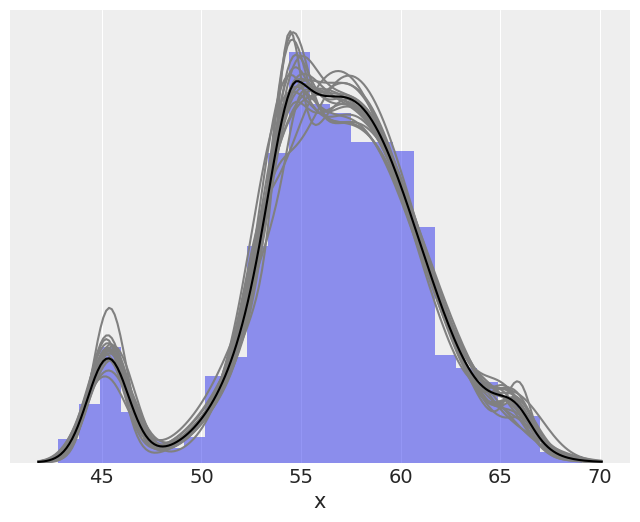

In [31]:
plt.figure(figsize=(8, 6))

plt.hist(cs_exp.values, bins=25, density=True, alpha=0.5)
plt.plot(x_plot, post_pdfs[::100].T, c='0.5')
plt.plot(x_plot, post_pdfs.mean(axis=0), c='k')

plt.xlabel('x')
plt.yticks([])
plt.savefig('B11197_06_15.png')

In [27]:
## Exercises
#clusters = 3
#n_cluster = [200, 150, 170]
#n_total = sum(n_cluster)
#means = [5, 0, -3]
#std_devs = [2, 2, 2]
#mix = np.random.normal(np.repeat(means, n_cluster),
#np.repeat(std_devs, n_cluster))
#az.plot_kde(np.array(mix));